In [1]:
!pip install –upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib > /dev/null

ERROR: Invalid requirement: '–upgrade'


https://github.com/youtube/api-samples/blob/master/python/comment_threads.py

https://github.com/youtube/api-samples/blob/master/python/comment_handling.py

### Want youtube video comments needs to be auto replied by LLM? 

- Get the Youtube Data API enabled

- Get the API credentials ready from the Google Console

- Find out how to get the Youtube API to work. Ask Youtube itself for the answer and a helpful video like below will be available
https://www.youtube.com/watch?v=qz8GaznXij4

- Take the code for getting the API connected, and then understand how to list, insert and reply to comments. The functions below will do the same.

#### The part where LLM enters the play.

- Comment for which you want the reply to be provided, has to be fed to the LLM

- The comment needs to be classified, as appreciation, neutral, positive feedback, critical feedback, negative comment, a question. 

- If positive or neutral, just a heart felt thanks would suffice. 

- For the rest of the feedbacks appropriate replies needs to be provided by the LLM.These needs to be coded into the prompt template.

- Some strict guidelines needs to be provided to the model, like
 
   a) How many words the reply can be.
   
   b) The word feedback can be mentioned
   
   c) End by saying that, the issue at hand will be looked into
   
- For the questions the model can be allowed to answer directly.



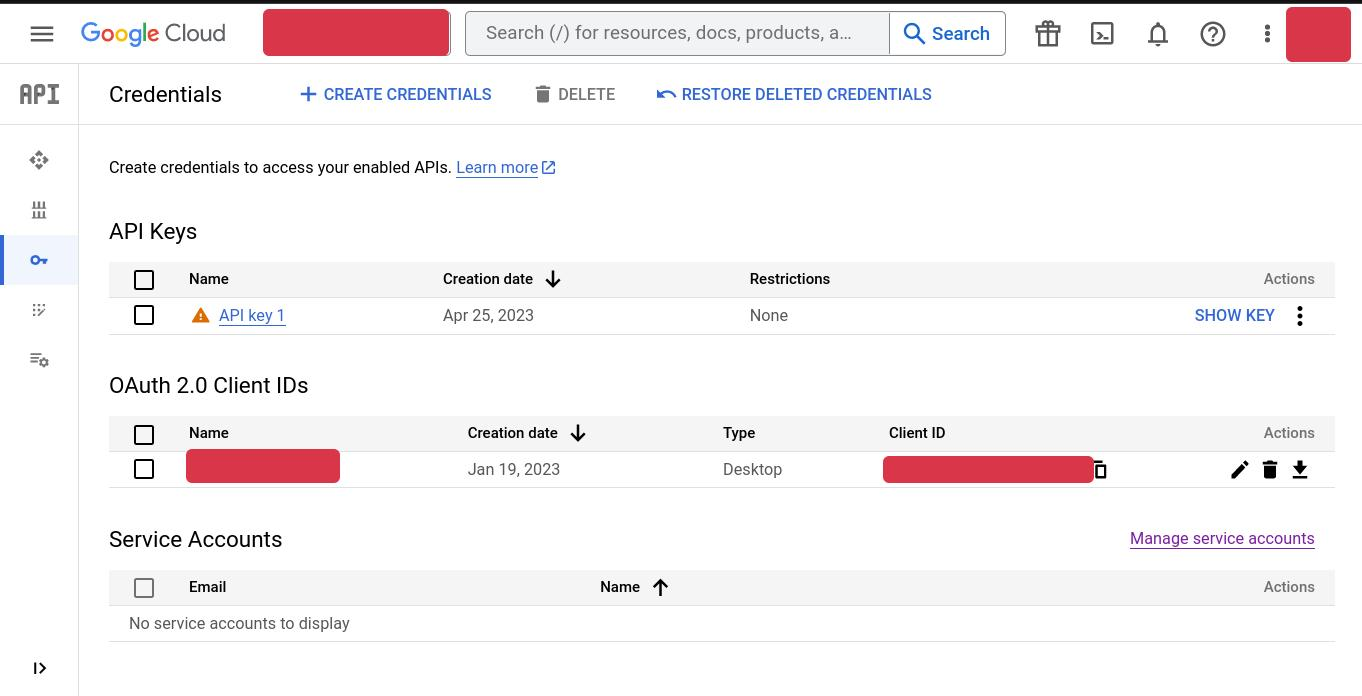

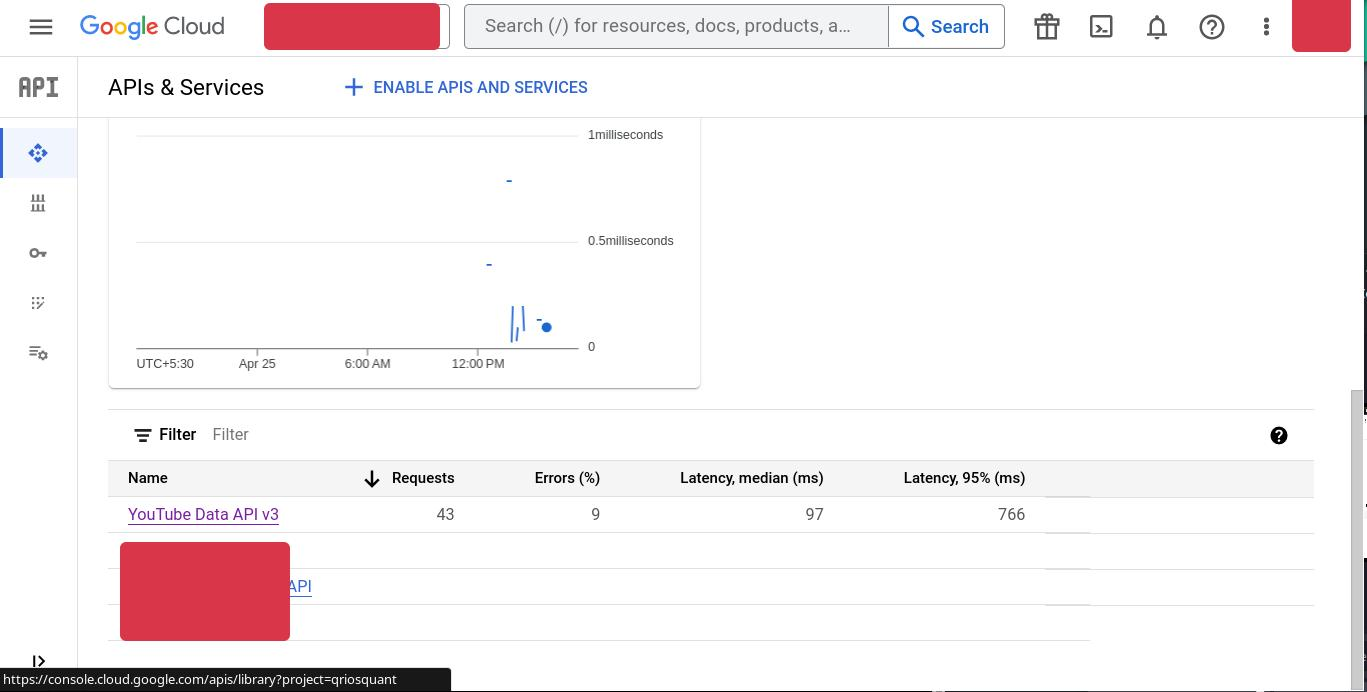

In [1]:
import os
import datetime
from collections import namedtuple
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from google.oauth2.credentials import Credentials
from google.auth.transport.requests import Request

In [2]:
def create_service(client_secret_file, api_name, api_version, *scopes, prefix=''):
    CLIENT_SECRET_FILE = client_secret_file
    API_SERVICE_NAME = api_name
    API_VERSION = api_version
    SCOPES = [scope for scope in scopes[0]]
    
    creds = None
    working_dir = os.getcwd()
    token_dir = 'token files'
    token_file = f'token_{API_SERVICE_NAME}_{API_VERSION}{prefix}.json'

    ### Check if token dir exists first, if not, create the folder
    if not os.path.exists(os.path.join(working_dir, token_dir)):
        os.mkdir(os.path.join(working_dir, token_dir))

    if os.path.exists(os.path.join(working_dir, token_dir, token_file)):
        creds = Credentials.from_authorized_user_file(os.path.join(working_dir, token_dir, token_file), SCOPES)
        # with open(os.path.join(working_dir, token_dir, token_file), 'rb') as token:
        #   cred = pickle.load(token)

    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRET_FILE, SCOPES)
            creds = flow.run_local_server(port=0)

        with open(os.path.join(working_dir, token_dir, token_file), 'w') as token:
            token.write(creds.to_json())

    try:
        service = build(API_SERVICE_NAME, API_VERSION, credentials=creds, static_discovery=False)
        print(API_SERVICE_NAME, API_VERSION, 'service created successfully')
        return service
    except Exception as e:
        print(e)
        print(f'Failed to create service instance for {API_SERVICE_NAME}')
        os.remove(os.path.join(working_dir, token_dir, token_file))
        return None

def convert_to_RFC_datetime(year=1900, month=1, day=1, hour=0, minute=0):
    dt = datetime.datetime(year, month, day, hour, minute, 0).isoformat() + 'Z'
    return dt


In [3]:
CLIENT_FILE = 'client_secret.json'
API_NAME = 'youtube'
API_VERSION = 'v3'
SCOPES = [
	'https://www.googleapis.com/auth/youtube',
	'https://www.googleapis.com/auth/youtube.force-ssl',
	'https://www.googleapis.com/auth/youtubepartner'
]


In [4]:
service = create_service(CLIENT_FILE, API_NAME, API_VERSION, SCOPES)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=1005487433681-prrvprs0u0va23kr55ln9h84afvg6aqs.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A55211%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutubepartner&state=sLWCrwv0s1YeJEwGsB2xArOPbKBeKl&access_type=offline


Gtk-Message: 17:44:09.101: Failed to load module "xapp-gtk3-module"
Gtk-Message: 17:44:09.118: Failed to load module "xapp-gtk3-module"
Gtk-Message: 17:44:09.119: Failed to load module "canberra-gtk-module"
Gtk-Message: 17:44:09.120: Failed to load module "canberra-gtk-module"


Stub sandbox ignoring command: /app/extra/nacl_helper


[2:2:0425/174417.139517:ERROR:nacl_fork_delegate_linux.cc(313)] Bad NaCl helper startup ack (0 bytes)
Gtk-Message: 17:44:18.129: Failed to load module "xapp-gtk3-module"
Gtk-Message: 17:44:18.130: Failed to load module "xapp-gtk3-module"
Gtk-Message: 17:44:18.130: Failed to load module "canberra-gtk-module"
Gtk-Message: 17:44:18.130: Failed to load module "canberra-gtk-module"


Opening in existing browser session.
youtube v3 service created successfully


In [14]:
def get_comments(youtube, video_id):
  results = youtube.commentThreads().list(
    part="snippet",
    videoId=video_id,
    #channelId='UCRkoxQy1AuX8dT8WYnw0w-w',
    textFormat="plainText"
  ).execute()

  comments = []
  #print(results)
  for item in results["items"]:
    comment = item["snippet"]["topLevelComment"]
    author = comment["snippet"]["authorDisplayName"]
    text = comment["snippet"]["textDisplay"]
    comment_id = item['id']
    comments.append({"comment":text,
                     "comment_id":comment_id})
    
  return comments

In [13]:
def insert_comment(youtube, channel_id, video_id, text):
  insert_result = youtube.commentThreads().insert(
    part="snippet",
    body=dict(
      snippet=dict(
        channelId=channel_id,
        videoId=video_id,
        topLevelComment=dict(
          snippet=dict(
            textOriginal=text
          )
        )
      )
    )
  ).execute()

  comment = insert_result["snippet"]["topLevelComment"]
  author = comment["snippet"]["authorDisplayName"]
  text = comment["snippet"]["textDisplay"]

In [12]:
def reply_comment(youtube, comment_id, text):
  insert_result = youtube.comments().insert(
    part="snippet",
    body=dict(
      snippet=dict(
        parentId=comment_id,
        textOriginal=text
      )
    )
  ).execute()

  author = insert_result["snippet"]["authorDisplayName"]
  text = insert_result["snippet"]["textDisplay"]

In [55]:
reply_comment(youtube=service,
             comment_id=comment_id,
             text='Nice room decor video')

In [18]:
import os
os.environ['OPENAI_API_KEY']='sk-xxxx'

In [8]:
from langchain import PromptTemplate, OpenAI, LLMChain

prompt_template = """
You are a helpful youtube comment replying bot. The following 
{comment} will be provided to you. Use following conditions to reply.
If the comment is appreciative, positive feedback or neutral then
reply 'Thanks for your feedback.'
If the comment is critical feedback then reply 'Sorry for the 
inconvenience. We will look into the issue and get back'
If the comment is a question. Then you can try to answer the question 
in 25 words. If you don't know the answer, then say you don't know.
"""

llm = OpenAI(temperature=0)

llm_chain = LLMChain(
    llm=llm,
    prompt=PromptTemplate.from_template(prompt_template)
)


In [9]:
llm_chain("""I have not seen anywhere any mention to the resolution of rendered images. How big or what size can you get from this?'""")

{'comment': "I have not seen anywhere any mention to the resolution of rendered images. How big or what size can you get from this?'",
 'text': "\nSorry, I don't know the exact resolution of the rendered images. However, you can adjust the size of the images according to your needs."}

In [69]:
llm_chain("""This is one of best videos I have watched""")

{'comment': 'This is one of best videos I have watched',
 'text': '\nThanks for your feedback. We appreciate your support.'}

In [70]:
llm_chain("""This is one of the worst videos I have watched""")

{'comment': 'This is one of the worst videos I have watched',
 'text': '\nSorry for the inconvenience. We will look into the issue and get back.'}

In [71]:
llm_chain("""This is an informative video""")

{'comment': 'This is an informative video',
 'text': '\nThanks for your feedback! We appreciate your support.'}

In [10]:
videoId='3igkDV0_qfg'

In [15]:
comments = get_comments(youtube=service,
                       video_id=videoId)

In [16]:
#get the comments
comments

[{'comment': 'good explanation! please continue doing this. Just few suggestions to improve viewer experience: please try to avoid quick screen scrolling up and down, also, sometimes sound a little loud and its hard to keep listening. \nBut in general very good education content, thank you 🙏',
  'comment_id': 'UgzuXk0Zw7C1ZvQgzoB4AaABAg'},
 {'comment': 'Really applaud your content on different topics on langchain and LLMs. Keep doing it. These videos can be useful to so many people in the present and future too.',
  'comment_id': 'Ugyb4aic1Qsz8ckOLjh4AaABAg'},
 {'comment': 'Amazing Content Bro🔥',
  'comment_id': 'UgzSGu9jHUDqVSlQc4t4AaABAg'},
 {'comment': 'Chatgpt is limited till 2021, otherwise, we can ask chatgpt itself to generate code using langchain framework.',
  'comment_id': 'Ugx83T-E_hUAaX6y7DV4AaABAg'},
 {'comment': 'Amazing! Been working through this very thing! And I put all your notebooks in my Pycharm and run it through the editor and have been having a ton of fun…keep ‘e

In [20]:
import time

#decide the video you want to automate
videoId = '3igkDV0_qfg'

#get the present comments 

initial_comments = len(get_comments(youtube=service,video_id=videoId))
print(initial_comments)

#the logic will be in endless loop
while True:
    
    new_comments = get_comments(youtube=service,
                       video_id=videoId) 
    
    if len(new_comments) > initial_comments:
        
        recent_comment = new_comments[0]['comment']
        
        recent_id = new_comments[0]['comment_id']
        
        print(recent_comment)
        
        llm_reply = llm_chain(recent_comment)['text']
        
        print(llm_reply)
        
        reply_comment(youtube=service,
                      comment_id=recent_id, 
                      text=llm_reply)
        
        initial_comments = len(new_comments) 
    
    #Sleep for 5 minutes
    
    time.sleep(30)

7


KeyboardInterrupt: 